# 01_03.Regression(예측)_하이퍼파라미터 튜닝과 최적화
- CV(교차분석): https://scikit-learn.org/stable/modules/cross_validation.html
- 하이퍼파라미터 튜닝: https://scikit-learn.org/stable/modules/grid_search.html
- 검증곡선: https://scikit-learn.org/stable/modules/learning_curve.html
- 예측모델검증: https://scikit-learn.org/stable/modules/model_evaluation.html
- 예측모델: 3.3.4. Regression metrics

## 1.기본 package 설정

In [ ]:
# 그래프에서 한글 폰트 인식하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

#  *** 런타임 다시 시작

In [ ]:
## 1.기본
import numpy as np  # numpy 패키지 가져오기
import matplotlib.pyplot as plt # 시각화 패키지 가져오기
import seaborn as sns # 시각화

## 2.데이터 가져오기
import pandas as pd # csv -> dataframe으로 전환

## 3.데이터 전처리
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# 4. 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split

## 5.모델구축
# from sklearn import linear_model
from sklearn.linear_model import Lasso     # 파라미터 튜닝을 위해 lasso 모델로 변경

## 6.모델검정
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 7.최적화
from sklearn.model_selection import GridSearchCV # 하이퍼파라미터 튜닝

## 2.데이터 불러오기

### 2.1 구글 드라이브와 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.2 데이터 프레임으로 저장
- 원본데이터(csv)를 dataframe 형태로 가져오기(pandas)

In [ ]:
housing_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/주택가격.csv', encoding="cp949")
housing_df.head()

,id,가격,연면적,품질,상태,건축년도,리모델링년도,지하면적,차고면적,면적_1층,면적_2층,주거유형,판매유형,판매조건
0,1,208500,8450,7,5,2003,2003,856,548,856,854,1,1,1
1,2,181500,9600,6,8,1976,1976,1262,460,1262,0,1,1,1
2,3,223500,11250,7,5,2001,2002,920,608,920,866,1,1,1
3,4,140000,9550,7,5,1915,1970,756,642,961,756,1,1,2
4,5,250000,14260,8,5,2000,2000,1145,836,1145,1053,1,1,1


### 2.3 자료구조 살펴보기

In [ ]:
housing_df.shape

In [ ]:
housing_df.info()

In [ ]:
housing_df.columns

## 3.데이터 전처리

### 3.1 필요없는 변수 제거

In [ ]:
housing_df = housing_df.drop (['id'], axis=1)
housing_df.head()

,가격,연면적,품질,상태,건축년도,리모델링년도,지하면적,차고면적,면적_1층,면적_2층,주거유형,판매유형,판매조건
0,208500,8450,7,5,2003,2003,856,548,856,854,1,1,1
1,181500,9600,6,8,1976,1976,1262,460,1262,0,1,1,1
2,223500,11250,7,5,2001,2002,920,608,920,866,1,1,1
3,140000,9550,7,5,1915,1970,756,642,961,756,1,1,2
4,250000,14260,8,5,2000,2000,1145,836,1145,1053,1,1,1


### 3.2 범주형 변수 처리
- 가변수 처리시 문자로 처리를 해야 변수명 구분이 쉬움

In [ ]:
housing_df['주거유형'] = housing_df['주거유형'].replace ([1,2,3,4,5], ['단독주택','2가구변경','듀플렉스','타운젠트바깥쪽','타운젠트안쪽'])
housing_df['판매유형'] = housing_df['판매유형'].replace ([1,2], ['보증증서','법원관리증서'])
housing_df['판매조건'] = housing_df['판매조건'].replace ([1,2], ['정상판매','압류및공매도'])
housing_df.head()

,가격,연면적,품질,상태,건축년도,리모델링년도,지하면적,차고면적,면적_1층,면적_2층,주거유형,판매유형,판매조건
0,208500,8450,7,5,2003,2003,856,548,856,854,단독주택,보증증서,정상판매
1,181500,9600,6,8,1976,1976,1262,460,1262,0,단독주택,보증증서,정상판매
2,223500,11250,7,5,2001,2002,920,608,920,866,단독주택,보증증서,정상판매
3,140000,9550,7,5,1915,1970,756,642,961,756,단독주택,보증증서,압류및공매도
4,250000,14260,8,5,2000,2000,1145,836,1145,1053,단독주택,보증증서,정상판매


## 4.데이터 탐색

### 4.1 EDA 데이터 탐색

In [ ]:
# 수치형 변수
housing_df.describe().round(2).T

In [ ]:
# 범주형 변수
# lecture_df.columns
categorical_features=['주거유형', '판매유형', '판매조건']

for col in categorical_features:
    cat = housing_df[col].value_counts()
    print(cat)

### 4.2 그래프 그리기

In [ ]:
# 한글 폰트 인식
plt.rc('font', family='NanumBarunGothic')

In [ ]:
# 수치형 변수
g = sns.pairplot(housing_df)

In [ ]:
# 변수별 선형회귀직선
variables = ['연면적', '품질', '상태', '건축년도', '리모델링년도', '지하면적',
             '차고면적', '면적_1층', '면적_2층']

for var in variables:
    plt.figure()
    sns.regplot(x = var, y = '가격', data = housing_df).set(title=f'{var} and 가격에 따른 회귀직선');

In [ ]:
# 범주형 변수
for col in categorical_features:
    sns.countplot(x=col, data = housing_df)
    plt.show()

### 4.3 base accuracy


In [ ]:
# base accuracy
housing_df['가격'].mean()

## 5.훈련/테스트용 데이터 분할


### 5.1 data와 target으로 분리
- data: X, target: y 로 분리

- X 추출


In [ ]:
X = housing_df.drop (['가격'], axis=1)
X.head()

,연면적,품질,상태,건축년도,리모델링년도,지하면적,차고면적,면적_1층,면적_2층,주거유형,판매유형,판매조건
0,8450,7,5,2003,2003,856,548,856,854,단독주택,보증증서,정상판매
1,9600,6,8,1976,1976,1262,460,1262,0,단독주택,보증증서,정상판매
2,11250,7,5,2001,2002,920,608,920,866,단독주택,보증증서,정상판매
3,9550,7,5,1915,1970,756,642,961,756,단독주택,보증증서,압류및공매도
4,14260,8,5,2000,2000,1145,836,1145,1053,단독주택,보증증서,정상판매


- target(y) 추출
- y 값을 series에서 배열로 변환

In [ ]:
y = housing_df['가격']
y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: 가격, dtype: int64

In [ ]:
# 선형모델의 y 값 표준화
y = StandardScaler().fit_transform(y[:, np.newaxis]).flatten()
y

<ipython-input-9-86a83c11e717>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = StandardScaler().fit_transform(y[:, np.newaxis]).flatten()


array([ 0.87174655,  0.3601134 ,  1.15598719, ...,  1.97081036,
       -0.38601829, -0.28416539])

### 5.2 훈련용 및 테스트용 데이터 분할
- test_size: 검증데이터 30%
- random_state : random seed 번호 = 1
- stratify : y(클래스)의 비율에 따라 분할(분류모형일때 사용)

In [ ]:
# \ 이후에 space 없어야 함
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 1)

In [ ]:
X_train.info()

In [ ]:
y_train.shape

In [ ]:
X_test.info()

In [ ]:
y_test.shape

## 6.pipeline으로 데이터 전처리
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
- R에서 recipe
- 범주형 변수: OneHotEncoder
- 수치형 변수:
- 선형모델은 StandardScaler 로 표준화
- tree형 모델은 데이터 원형 사용

### 6.1 preprocess 세팅

In [ ]:
# pipeline으로 세팅
# 수치형 변수(y는 제외)
numeric_features = ['연면적', '품질', '상태', '건축년도', '리모델링년도',
                    '지하면적', '차고면적', '면적_1층', '면적_2층']

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')), # 누락된 값은 중앙값으로 처리
        ('scaler', StandardScaler())
    ]
)

# 범주형 변수(y는 제외)
categorical_features=['주거유형', '판매유형', '판매조건']

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant',
                                  fill_value='missing')),  # 누락된 값은 missing으로 상수 처리
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

# preprocessor로 데이터 변환 세팅
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [ ]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['연면적', '품질', '상태', '건축년도', '리모델링년도', '지하면적',
                                  '차고면적', '면적_1층', '면적_2층']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['주거유형', '판매유형', '판매조건'])])

### 6.2 데이터 전처리 결과 확인
- https://www.kaggle.com/code/thomasswain/titanic-classifier

In [ ]:
pd.DataFrame(preprocessor.fit_transform(X_train)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.596577,-0.709282,1.204375,0.067463,-0.614537,-0.610066,0.965758,-1.005785,-0.789563,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.494475,-1.529824,-0.588082,-0.106458,-0.860567,-0.093881,-0.052596,-0.425396,-0.789563,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,-0.075530,-0.709282,-0.588082,0.206599,-0.417714,-0.265943,-2.343893,-0.618859,1.430503,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-2.147846,-0.709282,-0.588082,0.067463,-0.614537,-0.981073,-0.010165,-1.422939,0.875486,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,-0.894487,-0.709282,-1.484311,-1.115198,-1.598655,-0.265943,-1.070950,-0.618859,0.320470,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


## 7.모델만들기 (모델 설정)
- R에서 workflow
- 예측모델: 000_reg
- 분류모델: 000_clf

### 7.1 pipeline으로 모델 연결

In [ ]:
lr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("lr_reg", Lasso())                           # LinearRegression(Lasso)
    ]
)

### 7.2 하이퍼파라미터 세팅
- 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝
- 기계학습 모델의 성능을 결정하는 하이퍼 파라미터 튜닝

In [ ]:
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'lr_reg', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__keep_empty_features', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imput

In [ ]:
lr_grid = {
    "lr_reg__tol" : np.logspace(-5,-1,5) ,     # [1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]
    "lr_reg__alpha" : np.logspace(-5,-1,5),    # [0.00001, 0.0001, 0.001, 0.01, 0.1]
}

lr_grid

{'lr_reg__tol': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]),
 'lr_reg__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}

### 7.3 하이퍼파라미터 그리드 만들기

In [ ]:
lr_gs = GridSearchCV(estimator = lr_pipe,
                     param_grid = lr_grid,
                     scoring='r2',             # mse, r2
                     cv = 10,
                     n_jobs = -1,
                     verbose = 10,              # 프로세스 진행사항 확인
                     return_train_score = True) # 훈련결과 저장

## 8.모델 훈련(모델 학습)
- machine learning

### 8.1 모델 훈련하기(learning)

In [ ]:
lr_gs.fit(X_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['연면적',
                                                                          '품질',
                                                                          '상태',
                                                                          '건축년도',
                                                                          '리모델링년도',
                                                                          '지하면적',
                                                                          '차고면적',
                                                                          '면적_1층',
                                                                          '면적_2층']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['주거유형',
                                                                          '판매유형',
                                                                          '판매조건'])])),
                                       ('lr_reg', Lasso())]),
             n_jobs=-1,
             param_grid={'lr_reg__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]),
                         'lr_reg__tol': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])},
             return_train_score=True, scoring='r2', verbose=10)

### 8.2 검증 곡선으로 Tuning 결과 확인
- 결과 표로 정리: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#sphx-glr-auto-examples-model-selection-plot-grid-search-stats-py
- 그래프로 정리: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

In [ ]:
# 결과확인
lr_gs.cv_results_

{'mean_fit_time': array([0.0402786 , 0.04653025, 0.04062257, 0.04087148, 0.03171818,
        0.03338377, 0.03261859, 0.03014886, 0.02988589, 0.03222594,
        0.02738278, 0.03022246, 0.03024795, 0.02064877, 0.01654003,
        0.01618557, 0.01818132, 0.01858594, 0.01557362, 0.01624188,
        0.01711853, 0.01724534, 0.01700163, 0.01717811, 0.01352601]),
 'std_fit_time': array([0.00733135, 0.01006435, 0.01304263, 0.00913607, 0.00384695,
        0.00686914, 0.00620117, 0.01391677, 0.00711936, 0.00647528,
        0.00331943, 0.00447253, 0.00644019, 0.00851458, 0.00136899,
        0.00165281, 0.00537426, 0.00410946, 0.00044463, 0.00214847,
        0.00194743, 0.00195076, 0.00199987, 0.00261772, 0.00261975]),
 'mean_score_time': array([0.01675622, 0.01254828, 0.01270471, 0.01243012, 0.0131629 ,
        0.0131521 , 0.01181653, 0.0135509 , 0.01170759, 0.0139976 ,
        0.01136184, 0.01186728, 0.01288545, 0.00848832, 0.00722036,
        0.00697348, 0.00705061, 0.00735276, 0.00728002, 0.00

In [ ]:
# 분석결과를 표로 정리
results_df = pd.DataFrame(lr_gs.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
0.001_0.01,"{'lr_reg__alpha': 0.001, 'lr_reg__tol': 0.01}",1,0.856981,0.030202
0.0001_0.01,"{'lr_reg__alpha': 0.0001, 'lr_reg__tol': 0.01}",2,0.856973,0.029838
0.0001_0.001,"{'lr_reg__alpha': 0.0001, 'lr_reg__tol': 0.001}",3,0.856961,0.029843
0.0001_0.0001,"{'lr_reg__alpha': 0.0001, 'lr_reg__tol': 0.0001}",4,0.856951,0.029843
0.0001_1e-05,"{'lr_reg__alpha': 0.0001, 'lr_reg__tol': 1e-05}",5,0.856950,0.029843
0.001_0.001,"{'lr_reg__alpha': 0.001, 'lr_reg__tol': 0.001}",6,0.856947,0.030174
0.001_0.0001,"{'lr_reg__alpha': 0.001, 'lr_reg__tol': 0.0001}",7,0.856940,0.030163
0.001_1e-05,"{'lr_reg__alpha': 0.001, 'lr_reg__tol': 1e-05}",8,0.856939,0.030160
1e-05_0.01,"{'lr_reg__alpha': 1e-05, 'lr_reg__tol': 0.01}",9,0.856927,0.029800


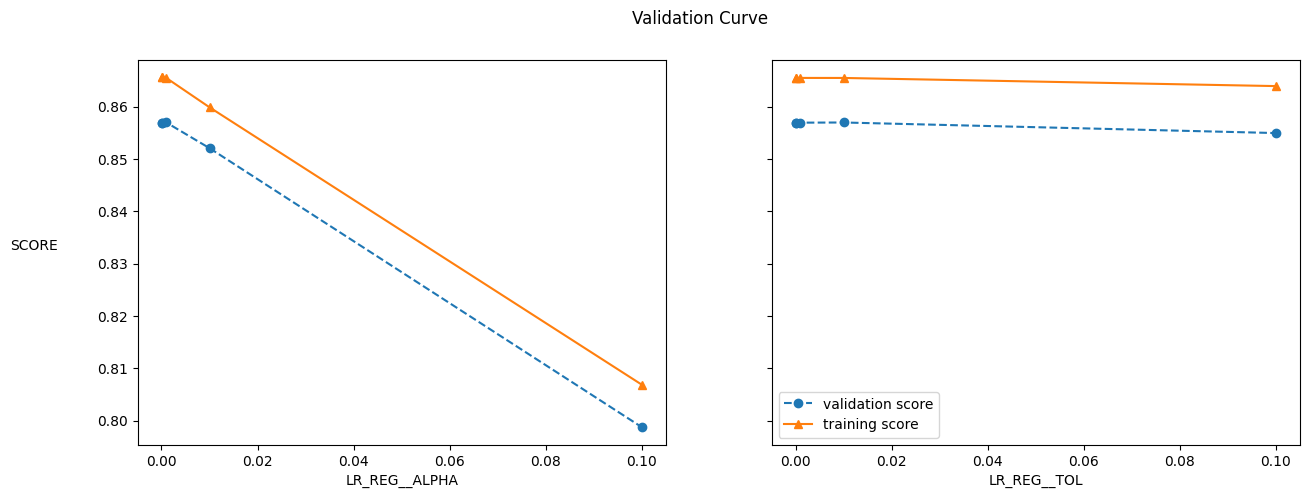

In [ ]:
# 튜닝결과 그래프
results = lr_gs.cv_results_
means_test = results['mean_test_score']
means_train = results['mean_train_score']

masks = []
masks_names = list(lr_gs.best_params_.keys())
for p_k, p_v in lr_gs.best_params_.items():
    masks.append(list(results['param_'+p_k].data==p_v))

params = lr_gs.param_grid

fig, ax = plt.subplots(1,len(params),
                       sharex='none',
                       sharey='all',
                       figsize=(15,5))
fig.suptitle('Validation Curve')
fig.text(0.04, 0.5, 'SCORE')

for i, p in enumerate(masks_names):
    m = np.stack(masks[:i] + masks[i+1:])           # np.stack: 결합
    best_parms_mask = m.all(axis=0)
    best_index = np.where(best_parms_mask)[0]
    x = np.array(params[p])
    y_1 = np.array(means_test[best_index])
    y_2 = np.array(means_train[best_index])
    ax[i].errorbar(x, y_1, linestyle='--', marker='o', label='validation score')
    ax[i].errorbar(x, y_2, linestyle='-', marker='^',label='training score' )
    ax[i].set_xlabel(p.upper())

plt.legend()
plt.show()

### 8.3 best 모델 설정

In [ ]:
# best 모델 파라미터 확인
print(lr_gs.best_score_)
print(lr_gs.best_params_)

0.8569814129020561
{'lr_reg__alpha': 0.001, 'lr_reg__tol': 0.01}


In [ ]:
# best 모델 파라미터를 최종모델로 훈련
best_reg = lr_gs.best_estimator_
best_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['연면적', '품질', '상태', '건축년도',
                                                   '리모델링년도', '지하면적', '차고면적',
                                                   '면적_1층', '면적_2층']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['주거유형', '판매유형', '판매조건'])])),
                ('lr_reg', Lasso(alpha=0.001, tol=0.01))])

In [ ]:
print(best_reg['lr_reg'])

Lasso(alpha=0.001, tol=0.01)


### 8.4 중요변수확인

In [ ]:
# 중요도 점수 계산
feature = best_reg['preprocessor'].get_feature_names_out()   # 수정
importances = best_reg["lr_reg"].coef_                       # 수정
importances = importances.flatten()                          # flatten() - 다차원 array를 1차원 array로 변환
output = pd.DataFrame([feature , importances],
                      index = ["feature","importances"]).T
output.sort_values(["importances"],
                   ascending= False ,
                   inplace=True)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


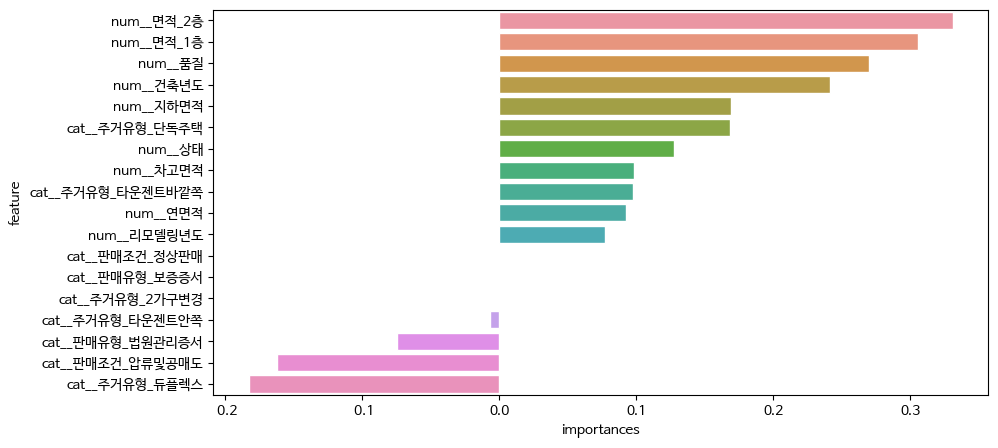

In [ ]:
# 그래프 그리기

plt.rc('font', family='NanumBarunGothic')

fig ,ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale = 1)
ax = sns.barplot(y="feature", x="importances", data=output)
plt.show()

## 9.모델 test 및 검정

### 9.1 검증용 데이터로 예측
- predict (class로 표시)
- predict_proba (확률값으로 표시): 분류모델에서 사용

In [ ]:
y_pred = best_reg.predict(X_test) # lr_reg -> lr_pipe
y_pred

array([ 1.10107166e+00, -1.13633194e+00, -2.05195112e+00,  7.53376719e-01,
        2.41950920e-01,  8.67025166e-01, -2.86758300e-01, -8.95991214e-01,
       -4.13263896e-01, -3.92392177e-01,  4.73775803e-02, -3.92392177e-01,
       -5.87695840e-01,  8.93048155e-02, -3.87138768e-01, -2.68046578e-01,
       -5.29992745e-02, -1.02166610e+00, -2.93242570e-01,  3.47388467e-01,
       -7.08068315e-01,  2.82391998e-01, -3.92392177e-01,  1.22028857e+00,
        1.25573903e+00,  1.43821415e+00,  1.08414235e-01, -9.38149215e-01,
        6.83419495e-01, -1.56696462e+00, -1.83800400e+00, -5.17975381e-01,
       -4.84245468e-01,  8.44852732e-01,  1.62120286e+00,  9.78294070e-01,
        1.96203961e+00,  5.51088488e-01,  8.47830050e-01,  1.04033078e+00,
       -2.91840357e-01,  1.51818938e-01,  8.96349131e-01, -6.03857879e-01,
        1.67160944e+00, -1.27095638e+00, -7.13621380e-01, -1.49665069e+00,
        8.85178446e-01, -3.51641347e-02,  8.29768186e-01, -6.64122871e-01,
        2.08250403e-01,  

### 9.2 실제값과 예측값 확인

In [ ]:
output = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
output

,Actual,Predicted
0,1.411804,1.101072
1,-1.023570,-1.136332
2,-1.705369,-2.051951
3,1.487601,0.753377
4,0.316530,0.241951
...,...,...
349,1.203361,0.989066
350,1.960938,1.214679
351,0.578031,0.358093
352,1.080190,1.161959


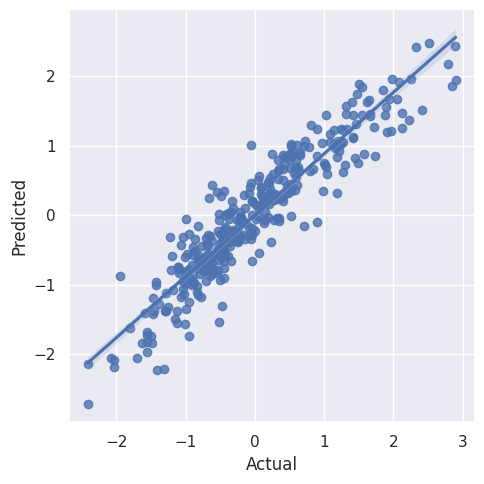

In [ ]:
sns.lmplot(x ='Actual', y ='Predicted', data = output)

### 9.3 모델 검정

In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
print('MSE: %.3f' % mean_squared_error(y_test,y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test,y_pred))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(y_test,y_pred)))
print('R2: %.3f' % r2_score(y_test,y_pred))

MSE: 0.131
MAE: 0.273
RMSE: 0.362
R2: 0.871
